In [1]:
# import torch
# import numpy as np
# from sklearn.base import BaseEstimator, RegressorMixin
# import node_kernel
# from concurrent.futures import ThreadPoolExecutor, wait
# import threading
# import pandas as pd
# import time

# class ErasplitGBDT(BaseEstimator, RegressorMixin):
#     def __init__(self, num_bins=10, max_depth=3, learning_rate=0.1, n_estimators=100):
#         self.num_bins = num_bins
#         self.max_depth = max_depth
#         self.learning_rate = learning_rate
#         self.n_estimators = n_estimators
#         self.device = "cuda"
#         self.out_feature = torch.zeros(1, device=self.device, dtype=torch.int32)
#         self.out_bin = torch.zeros(1, device=self.device, dtype=torch.int32)
#         self.max_nodes_per_tree = (2 ** (self.max_depth + 1)) - 1
#         self.total_max_nodes = self.n_estimators * self.max_nodes_per_tree
#         self.tree_offsets = [i * self.max_nodes_per_tree for i in range(self.n_estimators)]
#         self.num_workers = 1
#         self.executor = ThreadPoolExecutor(max_workers=self.num_workers)
#         self.stream_pool = [torch.cuda.Stream(device=self.device) for _ in range(self.num_workers)]


#     def fit(self, X, y, era_id):
#         self.bin_indices, _, self.bin_edges, self.unique_eras, self.Y_gpu = self.preprocess_gpu_data(X, y, era_id)
#         self.num_samples, self.num_features = X.shape
#         self.gradients = torch.zeros_like(self.Y_gpu)
#         self.base_prediction = self.Y_gpu.mean().item()
#         self.gradients += self.base_prediction
#         self.root_node_indices = torch.arange(self.num_samples, device=self.device)
#         self.tree_nodes = [None] * self.total_max_nodes
#         self.grow_forest()
#         return self

#     def preprocess_gpu_data(self, X_np, Y_np, era_id_np):
#         X = torch.from_numpy(X_np).float()
#         Y_gpu = torch.from_numpy(Y_np).float().to(self.device)
#         era_id_gpu = torch.from_numpy(era_id_np).int().to(self.device)

#         bin_edges = self.compute_quantile_bins(X, self.num_bins).float().contiguous()
#         bin_indices = torch.empty((X.shape[0], X.shape[1]), dtype=torch.int8)
#         for f in range(X.shape[1]):
#             bin_indices[:, f] = torch.bucketize(X[:, f], bin_edges[f], right=False).to(torch.int8)

#         bin_indices = bin_indices.to(self.device).contiguous()
#         bin_edges = bin_edges.to(self.device)
#         unique_eras, era_indices = torch.unique(era_id_gpu, return_inverse=True)

#         return bin_indices, era_indices, bin_edges, unique_eras, Y_gpu

#     def compute_quantile_bins(self, X, num_bins):
#         quantiles = torch.linspace(0, 1, num_bins + 1)[1:-1]
#         bin_edges = torch.quantile(X, quantiles, dim=0)
#         return bin_edges.T

#     def compute_histograms(self, bin_indices_sub, gradients):
#         grad_hist = torch.zeros((self.num_features, self.num_bins), device=self.device)
#         hess_hist = torch.zeros((self.num_features, self.num_bins), device=self.device)
#         node_kernel.compute_histogram(bin_indices_sub, gradients, grad_hist, hess_hist, self.num_bins)
#         return grad_hist, hess_hist

#     def find_best_split(self, gradient_histogram, hessian_histogram):
#         node_kernel.compute_split(
#             gradient_histogram.contiguous(),
#             hessian_histogram.contiguous(),
#             self.num_features, self.num_bins,
#             0.0, 1.0, 1e-6,
#             self.out_feature,
#             self.out_bin
#         )
#         return int(self.out_feature[0]), int(self.out_bin[0])

#     def grow_tree(self, gradient_histogram, hessian_histogram, node_indices, depth, idx, tree_offset):
#         thread_id = threading.get_ident()
#         # print(f"[Thread {thread_id}] ⛏️  Starting depth {depth} on stream {torch.cuda.current_stream().cuda_stream} (idx={idx})")  # 🔄 ADDED

#         if depth == self.max_depth:
#             leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
#             self.gradients[node_indices] += self.learning_rate * leaf_value
#             self.tree_nodes[idx] = {"leaf_value": leaf_value.item(), "samples": node_indices.numel()}
#             self.tree_node_counter += node_indices.numel()
#             return

#         best_feature, best_bin = self.find_best_split(gradient_histogram, hessian_histogram)
#         if best_feature == -1:
#             leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
#             self.gradients[node_indices] += self.learning_rate * leaf_value
#             self.tree_nodes[idx] = {"leaf_value": leaf_value.item(), "samples": node_indices.numel()}
#             self.tree_node_counter += node_indices.numel()
#             return

#         split_mask = self.bin_indices[node_indices, best_feature] <= best_bin
#         left_indices = node_indices[split_mask]
#         right_indices = node_indices[~split_mask]
#         if left_indices.numel() == 0 or right_indices.numel() == 0:
#             leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
#             self.gradients[node_indices] += self.learning_rate * leaf_value
#             self.tree_nodes[idx] = {"leaf_value": leaf_value.item(), "samples": node_indices.numel()}
#             self.tree_node_counter += node_indices.numel()
#             return

#         if left_indices.numel() < right_indices.numel():
#             grad_left, hess_left = self.compute_histograms(self.bin_indices[left_indices], self.residual[left_indices])
#             grad_right = gradient_histogram - grad_left
#             hess_right = hessian_histogram - hess_left
#         else:
#             grad_right, hess_right = self.compute_histograms(self.bin_indices[right_indices], self.residual[right_indices])
#             grad_left = gradient_histogram - grad_right
#             hess_left = hessian_histogram - hess_right

#         left_child_idx, right_child_idx = self.get_child_indices(idx - tree_offset)
#         left_child_idx += tree_offset
#         right_child_idx += tree_offset

#         # 🔄 ADDED: Submit left and right children using the current stream
#         self._submit_with_stream(grad_left, hess_left, left_indices, depth + 1, left_child_idx, tree_offset)
#         self._submit_with_stream(grad_right, hess_right, right_indices, depth + 1, right_child_idx, tree_offset)

#         self.tree_nodes[idx] = {
#             "feature": best_feature,
#             "bin": best_bin,
#             "left": left_child_idx,
#             "right": right_child_idx,
#         }

#     def _submit_with_stream(self, grad, hess, indices, depth, idx, tree_offset):  # 🔄 ADDED
#         stream = self.stream_pool[hash(threading.get_ident()) % self.num_workers]
#         self.executor.submit(self._grow_tree_with_stream, grad, hess, indices, depth, idx, tree_offset, stream)

#     def _grow_tree_with_stream(self, grad, hess, indices, depth, idx, tree_offset, stream):  # 🔄 ADDED
#         with torch.cuda.stream(stream):
#             self.grow_tree(grad, hess, indices, depth, idx, tree_offset)

#     def grow_forest(self):
#         for i in range(self.n_estimators):
#             tree_offset = self.tree_offsets[i]
#             root_idx = tree_offset
#             self.tree_node_counter = 0
#             self.residual = self.Y_gpu - self.gradients
#             grad_hist, hess_hist = self.compute_histograms(self.bin_indices, self.residual)

#             stream = self.stream_pool[i % self.num_workers]  # 🔄 ADDED
#             self.executor.submit(self._grow_tree_with_stream, grad_hist, hess_hist, self.root_node_indices, 0, root_idx, tree_offset, stream)  # 🔄 MODIFIED

#             while self.tree_node_counter < self.num_samples:
#                 time.sleep(0.001)

#     def get_child_indices(self, rel_idx):
#         return 2 * rel_idx + 1, 2 * rel_idx + 2

#     def predict_forest_batch(self, X_batch):
#         bin_indices = torch.empty((X_batch.shape[0], X_batch.shape[1]), dtype=torch.int8, device=self.device)
#         for f in range(X_batch.shape[1]):
#             bin_indices[:, f] = torch.bucketize(X_batch[:, f], self.bin_edges[f], right=False).to(torch.int8)
#         preds = torch.full((X_batch.shape[0],), self.base_prediction, dtype=torch.float32, device=self.device)
#         for i in range(self.n_estimators):
#             tree_offset = self.tree_offsets[i]
#             tree_preds = self._predict_tree_from_nodes(tree_offset, bin_indices)
#             preds += self.learning_rate * tree_preds
#         return preds

#     def _predict_tree_from_nodes(self, tree_offset, bin_indices):
#         n_samples = bin_indices.shape[0]
#         preds = torch.zeros(n_samples, device=self.device)
#         for i in range(n_samples):
#             node_idx = tree_offset
#             while True:
#                 node = self.tree_nodes[node_idx]
#                 if "leaf_value" in node:
#                     preds[i] = node["leaf_value"]
#                     break
#                 f = node["feature"]
#                 b = node["bin"]
#                 if bin_indices[i, f] <= b:
#                     node_idx = node["left"]
#                 else:
#                     node_idx = node["right"]
#         return preds

#     def predict(self, X):
#         X_tensor = torch.from_numpy(X).float().to(self.device)
#         preds = self.predict_forest_batch(X_tensor)
#         return preds.cpu().numpy()



In [11]:
import torch
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import pandas as pd
import node_kernel

class ErasplitGBDT(BaseEstimator, RegressorMixin):
    def __init__(self, num_bins=10, max_depth=3, learning_rate=0.1, n_estimators=100):
        self.num_bins = num_bins
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.forest = None
        self.bin_edges = None
        self.base_prediction = None
        self.unique_eras = None
        self.device = "cuda"
        self.root_gradient_histogram = None
        self.root_hessian_histogram = None
        self.gradients = None
        self.root_node_indices = None
        self.bin_indices = None
        self.Y_gpu = None
        self.num_features = None
        self.num_samples = None
        self.out_feature = torch.zeros(1, device=self.device, dtype=torch.int32)
        self.out_bin = torch.zeros(1, device=self.device, dtype=torch.int32)
        self.hist_subsample_threshold = 1000  # Default, tunable

    def fit(self, X, y, era_id):
        self.bin_indices, era_indices, self.bin_edges, self.unique_eras, self.Y_gpu = self.preprocess_gpu_data(X, y, era_id)
        self.gradients = torch.zeros_like(self.Y_gpu)
        self.root_node_indices = torch.arange(self.num_samples, device=self.device)
        self.base_prediction = self.Y_gpu.mean().item()
        self.gradients += self.base_prediction  # initialize with mean
        self.forest = self.grow_forest()
        return self

    def predict(self, X):
        X_tensor = torch.from_numpy(X).float().to(self.device)
        preds = self.predict_forest_batch( X_tensor )
        return preds.cpu().numpy()

    def compute_quantile_bins(self, X, num_bins):
        quantiles = torch.linspace(0, 1, num_bins + 1)[1:-1]  # Exclude 0% and 100%
        bin_edges = torch.quantile(X, quantiles, dim=0)  # shape: [B-1, F]
        return bin_edges.T  # shape: [F, B-1]
    
    def preprocess_gpu_data(self, X_np, Y_np, era_id_np):
        self.num_samples, self.num_features = X_np.shape
    
        Y_gpu = torch.from_numpy(Y_np).type(torch.float32).to(self.device)
        era_id_gpu = torch.from_numpy(era_id_np).type(torch.int32).to(self.device)
    
        # Check if X is pre-binned integer data
        is_integer_type = np.issubdtype(X_np.dtype, np.integer)
    
        if is_integer_type:
            max_vals = X_np.max(axis=0)
            if np.all(max_vals < self.num_bins):
                print("Detected pre-binned integer input — skipping quantile binning.")
                bin_indices = torch.from_numpy(X_np).to(self.device).contiguous().to(torch.int8)
                bin_edges = torch.arange(1, self.num_bins, dtype=torch.float32, device=self.device).repeat(self.num_features, 1)
                unique_eras, era_indices = torch.unique(era_id_gpu, return_inverse=True)
                return bin_indices, era_indices, bin_edges, unique_eras, Y_gpu
            else:
                print("Integer input detected, but values exceed num_bins — falling back to quantile binning.")
    
        # Else, do quantile binning
        X = torch.from_numpy(X_np).type(torch.float32)
        bin_edges = self.compute_quantile_bins(X, self.num_bins).type(torch.float32).contiguous().to(self.device)
    
        bin_indices = torch.empty((self.num_samples, self.num_features), dtype=torch.int8)
        for f in range(self.num_features):
            bin_indices[:, f] = torch.bucketize(X[:, f], bin_edges[f], right=False).type(torch.int8)
        bin_indices = bin_indices.to(self.device).contiguous()
    
        unique_eras, era_indices = torch.unique(era_id_gpu, return_inverse=True)
    
        return bin_indices, era_indices, bin_edges, unique_eras, Y_gpu


        
    def compute_histograms(self, bin_indices_sub, gradients):
        grad_hist = torch.zeros((self.num_features, self.num_bins), device=self.device, dtype=torch.float32)
        hess_hist = torch.zeros((self.num_features, self.num_bins), device=self.device, dtype=torch.float32)
    
        # Call the kernel
        node_kernel.compute_histogram(
            bin_indices_sub,#[:256],
            gradients,#[:256],
            grad_hist,
            hess_hist,
            self.num_bins
        )
    
        return grad_hist, hess_hist

    def estimate_required_sample_size(self, sigma, epsilon=0.01, confidence=0.95):
        z = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}[confidence]
        return int((z * sigma / epsilon) ** 2)

    def maybe_subsample_node(self, bin_indices_sub, gradients_sub, n, max_samples=1000, epsilon=0.01, confidence=0.95):
        if n <= max_samples:
            return bin_indices_sub, gradients_sub

        idx = torch.rand(n, device=self.device).topk(max_samples, largest=False).indices
        return bin_indices_sub[idx], gradients_sub[idx]

    def find_best_split(self, gradient_histogram, hessian_histogram):
        node_kernel.compute_split(
            gradient_histogram.contiguous(),
            hessian_histogram.contiguous(),
            self.num_features, self.num_bins,
            0.0, 1.0, 1e-6,
            self.out_feature,
            self.out_bin
        )
        
        f = int(self.out_feature[0])
        b = int(self.out_bin[0])
        return (f, b)
    
    def grow_tree(
        self,
        gradient_histogram,
        hessian_histogram,
        node_indices,
        depth
    ):
        if depth == self.max_depth:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            return {"leaf_value": leaf_value, "samples": node_indices.numel()}
    
        parent_size = node_indices.numel()
        use_subsampling = parent_size >= 2 * self.hist_subsample_threshold
    
        best_feature, best_bin = self.find_best_split(gradient_histogram, hessian_histogram)
    
        if best_feature == -1:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            return {"leaf_value": leaf_value, "samples": parent_size}
    
        split_mask = self.bin_indices[node_indices, best_feature] <= best_bin
        left_indices = node_indices[split_mask]
        right_indices = node_indices[~split_mask]
        left_size = left_indices.numel()
        right_size = right_indices.numel()
    
        if left_size == 0 or right_size == 0:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            return {"leaf_value": leaf_value, "samples": parent_size}
    
        # Compute child histograms
        if use_subsampling:
            grad_hist_left, hess_hist_left = self.compute_histograms(
                *self.maybe_subsample_node(
                    self.bin_indices[left_indices], 
                    self.residual[left_indices], 
                    left_size,
                    max_samples=self.hist_subsample_threshold
                )
            )
            grad_hist_right, hess_hist_right = self.compute_histograms(
                *self.maybe_subsample_node(
                    self.bin_indices[right_indices], self.residual[right_indices], right_size,
                    max_samples=self.hist_subsample_threshold
                )
            )
        else:
            if left_size < right_size:
                grad_hist_left, hess_hist_left = self.compute_histograms(
                    self.bin_indices[left_indices], self.residual[left_indices]
                )
                grad_hist_right = gradient_histogram - grad_hist_left
                hess_hist_right = hessian_histogram - hess_hist_left
            else:
                grad_hist_right, hess_hist_right = self.compute_histograms(
                    self.bin_indices[right_indices], self.residual[right_indices]
                )
                grad_hist_left = gradient_histogram - grad_hist_right
                hess_hist_left = hessian_histogram - hess_hist_right
    
        new_depth = depth + 1
        left_child = self.grow_tree(grad_hist_left, hess_hist_left, left_indices, new_depth)
        right_child = self.grow_tree(grad_hist_right, hess_hist_right, right_indices, new_depth)
    
        return {
            "feature": best_feature,
            "bin": best_bin,
            "left": left_child,
            "right": right_child
        }

    
    def grow_forest(self):
        forest = [{}] * self.n_estimators
        for i in range(self.n_estimators):
            self.residual = self.Y_gpu - self.gradients
            self.root_gradient_histogram, self.root_hessian_histogram = self.compute_histograms(self.bin_indices, self.residual)
            tree = self.grow_tree(self.root_gradient_histogram, self.root_hessian_histogram,self.root_node_indices, depth=0)            
            forest[i] = tree
    
        return forest
    
    def predict_from_tree_batch(self, tree, X_batch):
        N = X_batch.shape[0]
        predictions = torch.empty(N, device=X_batch.device)
    
        active_nodes = [tree for _ in range(N)]
        mask = torch.ones(N, dtype=torch.bool, device=X_batch.device)
    
        while mask.any():
            current_nodes = active_nodes
            new_nodes = [None] * N
            for i in torch.where(mask)[0]:
                node = current_nodes[i]
                if "leaf_value" in node:
                    predictions[i] = node["leaf_value"]
                    mask[i] = False
                else:
                    feature = node["feature"]
                    bin_threshold = node["bin"]
                    bin_index = torch.bucketize(X_batch[i, feature], self.bin_edges[feature], right=False)
                    new_nodes[i] = node["left"] if bin_index <= bin_threshold else node["right"]
    
            active_nodes = new_nodes
    
        return predictions
    
    def predict_forest_batch(self, X_batch ):
        N = X_batch.shape[0]
        preds = torch.full((N,), self.base_prediction if self.base_prediction is not None else 0.0, device=X_batch.device, dtype=torch.float32)
        for tree in self.forest:
            preds += self.learning_rate * self.predict_from_tree_batch(tree, X_batch)
    
        return preds

In [13]:
'''
Datasets:

1) Test 2D Dataset with visualization
2) Test High Dimensional Data Set
3) Numerai Data

'''


#1


# # Generate a simple 2D dataset
num_samples = 10000  # Keep it small for clarity

# Generate X in a fun spiral-ish pattern plus some noise
r = np.linspace(0.5, 2.5, num_samples)
theta = np.linspace(0, 4 * np.pi, num_samples)
X1 = r * np.cos(theta) + np.random.normal(0, 0.2, num_samples)
X2 = r * np.sin(theta) + np.random.normal(0, 0.2, num_samples)
X_np = np.stack([X1, X2], axis=1)

# Create a more interesting non-linear target
Y_np = (X_np[:, 0]**2 - X_np[:, 1]**2) + 0.5 * X_np[:, 0]
eras = np.zeros(num_samples)


#2

# def generate_spiral_dataset(num_samples=1_000_000, num_features=10, noise_std=0.2, seed=42):
#     np.random.seed(seed)

#     # Spiral base in 2D
#     r = np.linspace(0.5, 2.5, num_samples)
#     theta = np.linspace(0, 4 * np.pi, num_samples)
#     X1 = r * np.cos(theta) + np.random.normal(0, noise_std, num_samples)
#     X2 = r * np.sin(theta) + np.random.normal(0, noise_std, num_samples)
    
#     # Initial 2D spiral features
#     X = [X1, X2]
    
#     # Create additional synthetic features (some linear, some non-linear)
#     for i in range(2, num_features):
#         if i % 2 == 0:
#             X_i = np.sin(X1) * np.cos(X2) + np.random.normal(0, noise_std, num_samples)
#         else:
#             X_i = X1 * X2 + np.random.normal(0, noise_std, num_samples)
#         X.append(X_i)
    
#     X_np = np.stack(X, axis=1)

#     # Non-linear target function based on first few features
#     Y_np = (X1**2 - X2**2) + 0.5 * X1 + 0.3 * X_np[:, 2] - 0.2 * X_np[:, 3]

#     # Dummy eras
#     eras = np.zeros(num_samples, dtype=int)

#     return X_np, Y_np, eras

# X_np, Y_np, eras = generate_spiral_dataset(num_samples=1_000_000, num_features=10)

#3)

DATA_VERSION = "v5.0"
train = pd.read_parquet(f"../SignalMiner/{DATA_VERSION}/train.parquet")

s = 1_000_000 # num_samples
n = 1000 # num_features

feature_set = [ f for f in list(train) if 'feat' in f ]#[:n]
targets = [ t for t in list(train) if 'target' in t ]

X_np = train[feature_set].astype('int8').values#[:s]
Y_np = train[targets[0]].values#[:s]
eras = np.zeros(len(Y_np))
f"{len(feature_set) * len(X_np):,}"

'6,525,137,520'

In [14]:
max_depth = 7
num_bins = 5
n_estimators = 100
learning_rate = 0.1
era_model = ErasplitGBDT(
    max_depth = max_depth,
    num_bins = num_bins,
    n_estimators = n_estimators,
    learning_rate = learning_rate
)

# era_model.load_data( X_np, Y_np, eras)

In [15]:
import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
# era_model.init_data()
# era_model.grow_forest()
era_model.fit(X_np, Y_np, eras)

profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(20)  # Show top 20 functions


Detected pre-binned integer input — skipping quantile binning.
         311540 function calls (286159 primitive calls) in 123.183 seconds

   Ordered by: cumulative time
   List reduced from 82 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000  123.181   61.591 interactiveshell.py:3541(run_code)
        2    0.000    0.000  123.181   61.591 {built-in method builtins.exec}
        1    0.000    0.000  123.181  123.181 503212797.py:1(<module>)
        1    0.000    0.000  123.181  123.181 1274829804.py:31(fit)
        1    0.005    0.005  120.360  120.360 1274829804.py:200(grow_forest)
25480/100    5.593    0.000  120.352    1.204 1274829804.py:125(grow_tree)
    12692  107.987    0.009  108.111    0.009 1274829804.py:111(find_best_split)
    24156    3.173    0.000    5.410    0.000 1274829804.py:104(maybe_subsample_node)
        1    0.001    0.001    2.821    2.821 1274829804.py:50(preprocess_gpu_data)
  

In [18]:
preds = era_model.predict(X_np[:200])
np.corrcoef([preds, Y_np[:200]])

array([[1.        , 0.13062415],
       [0.13062415, 1.        ]])

In [7]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
    max_depth = max_depth, 
    n_estimators=n_estimators, 
    verbose=-1, 
    max_bins=num_bins, 
    learning_rate=learning_rate, 
    num_leaves=2**max_depth,
)

In [8]:

import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
model.fit(X_np, Y_np)

profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(20)  # Show top 20 functions


         16776 function calls (16382 primitive calls) in 1293.410 seconds

   Ordered by: cumulative time
   List reduced from 337 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000 1293.410  646.705 interactiveshell.py:3541(run_code)
        2    0.000    0.000 1293.410  646.705 {built-in method builtins.exec}
        1    0.000    0.000 1293.410 1293.410 3128535983.py:1(<module>)
        1    0.000    0.000 1293.410 1293.410 sklearn.py:1075(fit)
        1    0.000    0.000 1293.410 1293.410 sklearn.py:771(fit)
        1    0.004    0.004 1293.142 1293.142 engine.py:43(train)
      100 1144.039   11.440 1144.040   11.440 basic.py:3831(update)
        1   28.862   28.862  149.038  149.038 basic.py:3366(__init__)
        1    0.000    0.000  120.175  120.175 basic.py:2403(construct)
        1    0.231    0.231  120.169  120.169 basic.py:2001(_lazy_init)
        1   68.182   68.182  119.924  119.924 basic.py:

In [17]:
preds = model.predict(X_np[:200])
np.corrcoef([preds, Y_np[:200]])

array([[1.        , 0.10791714],
       [0.10791714, 1.        ]])

In [15]:

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     # Run the slow function
#     forest = grow_forest(num_trees, root_node_indices, bin_indices, Y_gpu, gradients, num_bins, max_depth, lr)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))



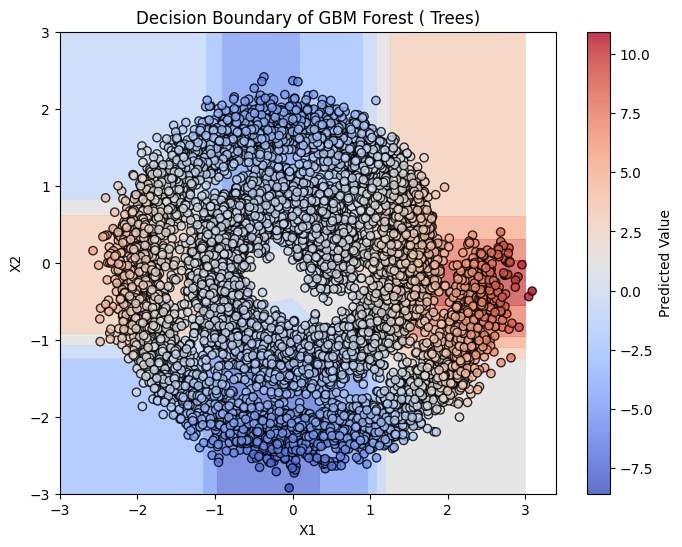

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size and range
grid_size = 15
x1_range = np.linspace(-3, 3, grid_size)
x2_range = np.linspace(-3, 3, grid_size)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid_np = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])  # Flatten for batch prediction
Z_grid = era_model.predict(X_grid_np)
plt.figure(figsize=(8, 6))
plt.contourf(X1_grid, X2_grid, Z_grid.reshape(grid_size,grid_size), cmap="coolwarm", alpha=0.7)
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, cmap="coolwarm", edgecolor="k", marker="o", alpha=0.8)
plt.colorbar(label="Predicted Value")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Decision Boundary of GBM Forest ( Trees)")
plt.show()


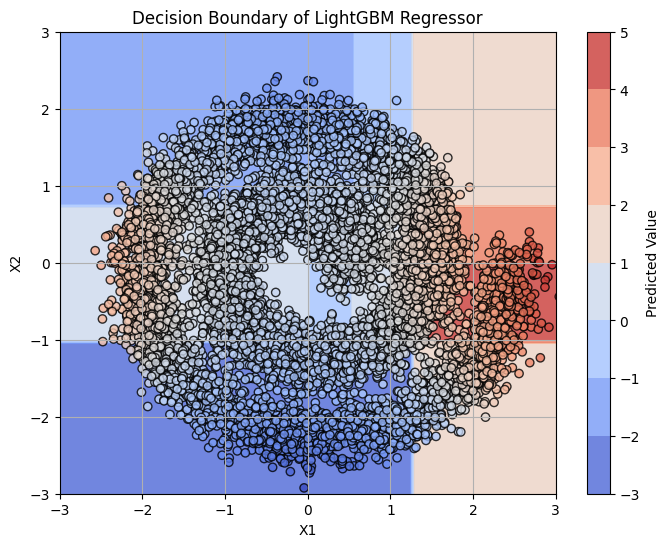

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a grid of values over the same domain as your training data
grid_size = 100
x1 = np.linspace(-3, 3, grid_size)
x2 = np.linspace(-3, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]  # shape: (grid_size**2, 2)

# Use LightGBM model to predict on the grid
Z = model.predict(X_grid)
Z = Z.reshape(X1.shape)

# Plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Z, cmap='coolwarm', alpha=0.8)
plt.colorbar(contour, label="Predicted Value")
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, edgecolor="k", cmap="coolwarm", alpha=0.8)
plt.title("Decision Boundary of LightGBM Regressor")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()


In [12]:
'''pytorch profiler'''

# import torch.profiler

# with torch.profiler.profile(
#     activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
#     record_shapes=True,
#     profile_memory=True,
#     with_stack=True
# ) as prof:
#     era_model.fit(X_np, Y_np, eras)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))


'pytorch profiler'